In [2]:
%matplotlib inline

from pathlib import Path
import time
import traceback
from importlib import reload

import numpy as np
import scipy.stats as stats
import pandas as pd
pd.set_option('display.max_rows', 50)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='muted')
from matplotlib_venn import venn2, venn3

from TreeMazeAnalyses2.Analyses import subject_info as si
from TreeMazeAnalyses2.Analyses import cluster_match_functions as cmf

from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches
import matplotlib.transforms as transforms
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import ipywidgets as widgets
from ipywidgets import interact, fixed, interact_manual

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']


In [3]:
%%time
si = reload(si)
subjects = ['Cl']
overwrite = False
update_clusters = False
for subject in subjects:
    subject_info = si.SubjectInfo(subject, overwrite=overwrite)
    if update_clusters:
        subject_info.update_clusters()

CPU times: user 88.5 ms, sys: 3.44 ms, total: 92 ms
Wall time: 93.5 ms


In [4]:
%%time
si = reload(si)
overwrite=False
dm = subject_info.get_cluster_dists(overwrite=overwrite)

CPU times: user 48.9 ms, sys: 7.44 ms, total: 56.3 ms
Wall time: 54.4 ms


In [5]:
%%time
si = reload(si)
overwrite=True
cm  = subject_info.match_clusters(overwrite=overwrite, require_subsets=False)

CPU times: user 204 ms, sys: 0 ns, total: 204 ms
Wall time: 206 ms


In [16]:
cm[14]

{'analysis': (4,
  12.5,
  ['Cl_OF_112918',
   'Cl_T3g_112918',
   'Cl_T3g_113018',
   'Cl_OF_113018',
   'Cl_T3g_120118_0001',
   'Cl_OF_120118',
   'Cl_T3g_120318',
   'Cl_OF_120318'],
  32,
  [2, 3, 3, 6, 5, 3, 5, 5]),
 'matches_dict': {'Cl_OF_112918-tt4_d12.5_cl0': [set()],
  'Cl_T3g_112918-tt4_d12.5_cl9': [{'Cl_OF_112918-tt4_d12.5_cl9'}],
  'Cl_OF_112918-tt4_d12.5_cl9': [{'Cl_T3g_112918-tt4_d12.5_cl9'}],
  'Cl_OF_113018-tt4_d12.5_cl2': [{'Cl_T3g_112918-tt4_d12.5_cl1'}],
  'Cl_T3g_112918-tt4_d12.5_cl1': [{'Cl_OF_113018-tt4_d12.5_cl2'}],
  'Cl_T3g_112918-tt4_d12.5_cl4': [set()],
  'Cl_T3g_120118_0001-tt4_d12.5_cl2': [{'Cl_OF_120118-tt4_d12.5_cl1',
    'Cl_T3g_113018-tt4_d12.5_cl8'},
   {'Cl_OF_120118-tt4_d12.5_cl1', 'Cl_T3g_120318-tt4_d12.5_cl0'}],
  'Cl_T3g_113018-tt4_d12.5_cl8': [{'Cl_OF_120118-tt4_d12.5_cl1',
    'Cl_T3g_120118_0001-tt4_d12.5_cl2'}],
  'Cl_OF_120118-tt4_d12.5_cl1': [{'Cl_T3g_113018-tt4_d12.5_cl8',
    'Cl_T3g_120118_0001-tt4_d12.5_cl2'},
   {'Cl_T3g_120118_0001-t

In [6]:
cmf = reload(cmf)
def get_clusters_match_info(analysis_num):
    
    n_wf = 100
    tt, d, sessions, n_cl, n_cl_session = dm[analysis_num]['analysis']
    n_wf_samps = 128
    wf = np.zeros( (n_cl, n_wf, n_wf_samps))
    cl_info = pd.DataFrame(index=np.arange(n_cl), columns=['snr', 'fr', 'isi_viol', 'session', 'set_num','cl', 'session_cl_id'])
    cl_info['session_cl_id'] = dm[analysis_num]['cl_names']

    cl_cnt = 0

    for session_num, session in enumerate(sessions):
        cl_tt_ids = subject_info.session_clusters[session]['cell_IDs'][tt]
        cl_idx = np.arange(n_cl_session[session_num])+cl_cnt

        wf[cl_idx] = subject_info.get_session_tt_wf(session, tt, cluster_ids=cl_tt_ids, n_wf=n_wf)

        cl_info.loc[cl_idx, 'snr'] = [subject_info.session_clusters[session]['clusters_snr'][tt][cl] for cl in cl_tt_ids]
        cl_info.loc[cl_idx, 'fr'] = [subject_info.session_clusters[session]['clusters_fr'][tt][cl] for cl in cl_tt_ids]
        cl_info.loc[cl_idx, 'isi_viol'] = [subject_info.session_clusters[session]['clusters_isi_viol_rate'][tt][cl] for cl in cl_tt_ids]

        cl_info.loc[cl_idx, 'session'] = session
        cl_info.loc[cl_idx, 'cl'] = np.array(cl_tt_ids).astype(int)

        cl_cnt += n_cl_session[session_num]

    for set_num, cl_set in enumerate(cm[analysis_num]['matches_sets']):
        cl_info.loc[cl_info.session_cl_id.isin(cl_set), 'set_num'] = set_num

    cl_info = cl_info.astype({'set_num': int})
    
    return wf, cl_info


def plot_cluster_match_sets(set_num):
    cl_set_info = cl_info[cl_info.set_num.isin([set_num])].copy() 
    
    cl_idx = cl_set_info.index
    cl_names = cl_set_info.session_cl_id.values
    
    wfm = np.median(wf[cl_idx], axis=1).T
    loc = [dm[analysis_num]['clusters_loc'][cl] for cl in cl_names]
    cov = [dm[analysis_num]['clusters_cov'][cl] for cl in cl_names]
    
    f, ax = plt.subplots(2,2,figsize=(12,10))
    ax = ax.flatten()
    
    ax[0].plot(wfm, linewidth=3)
    
    for jj in range(5):
        ax[0].axvline(32*jj, linestyle='--', color='0.2')
    
    ax[0].set_title("Waveforms")
    ax[0].set_ylabel(r"Amp [$\mu$V] ")
    
    aa=np.arange(0,129,32)
    ax[0].set_xticks(aa[:-1]+18)
    ax[0].set_xticklabels([f"ch{ch}" for ch in range(1,5)])
    
    cmf.plot_2d_cluster_ellipsoids(loc, cov, cl_names=cl_names, legend=True, ax=ax[1])
    ax[1].set_title(" Clusters ")
    
    table_cols = ['snr', 'fr', 'isi_viol']
    ax[2].axis('off')
    ax[2].axis('tight')
    
    t = ax[2].table(cellText = cl_set_info[table_cols].values, colLabels=table_cols, 
                    rowColours = colors, colWidths=[0.1,0.3,0.3], loc='center')
    
    t.scale(1, 1.7)
    t.set_fontsize(14)
    t.auto_set_column_width(col=list(range(4)))
    
    
    sns.heatmap(dm[analysis_num]['dists_mats']['pe'].loc[cl_names,cl_names], annot=True, ax=ax[3])
    ax[3].set_title('PE distance')
    
    return f, ax


In [7]:
def see_how_many_clusters(analysis_num):
    tt, d, sessions, n_cl, n_cl_session = dm[analysis_num]['analysis']
    print(f" Analysis #{analysis_num}, tt {tt}, depth {d}")
    print(f" Number of sessions {len(sessions)}")
    print(f" Number of total clusters {n_cl}")
    print(f" Number of unique sets { len(cm[analysis_num]['matches_sets'])} ")
    return

interact(see_how_many_clusters,analysis_num=(0, len(dm)-1));

interactive(children=(IntSlider(value=27, description='analysis_num', max=54), Output()), _dom_classes=('widge…

## explore individual sets

In [29]:
from ipywidgets.widgets.interaction import show_inline_matplotlib_plots
from IPython.display import display, clear_output

def analysis_str(analysis_num):
    tt, d, sessions, n_cl, n_cl_session = dm[analysis_num]['analysis']
    out_str = f"Analysis #{analysis_num}, tt {tt}, depth {d}\n" + \
              f" Number of sessions {len(sessions)}\n" + \
              f" Number of total clusters {n_cl}\n" + \
              f" Number of unique sets { len(cm[analysis_num]['matches_sets'])} \n"
    return out_str

def on_analysis_num_change(change):
    global wf
    global cl_info
    global analysis_num
    
    analysis_num = change.new
    with out:
        analysis_labels_w.value = analysis_str(analysis_num)
    
    wf, cl_info = get_clusters_match_info(analysis_num)
    set_num_w.options = range(len(cm[analysis_num]['matches_sets']))
    
def on_set_num_change(change):
    with out:
        clear_output()
        f, ax = plot_cluster_match_sets(change.new)
        show_inline_matplotlib_plots()
    #plt.show(f)

In [30]:
analysis_num = 0

n_analyses = len(dm)
analysis_w = widgets.Dropdown(description='analysis_num', options=range(n_analyses), value=analysis_num)
set_num_w = widgets.Dropdown(description='set_num', options=range(len(cm[analysis_num]['matches_sets'])))
analysis_labels_w = widgets.Label(value = analysis_str(analysis_num) )

out = widgets.Output()    
analysis_w.observe(on_analysis_num_change, names='value')
set_num_w.observe(on_set_num_change, names='value')

display(analysis_w, set_num_w, analysis_labels_w, out)

Dropdown(description='analysis_num', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18…

Dropdown(description='set_num', options=(0, 1), value=0)

Label(value='Analysis #0, tt 1, depth 12.0\n Number of sessions 2\n Number of total clusters 2\n Number of uni…

Output()

In [66]:
n_units = 0 
n_unique_units = 0
for analysis_num in dm.keys():
    tt, d, sessions, n_cl, n_cl_session = dm[analysis_num]['analysis']
    n_units += n_cl
    n_unique_units += len(cm[analysis_num]['matches_sets'])

print(f"Total Units: {n_units}")
print(f"Total Unique: {n_unique_units}")

Total Units: 606
Total Unique: 384


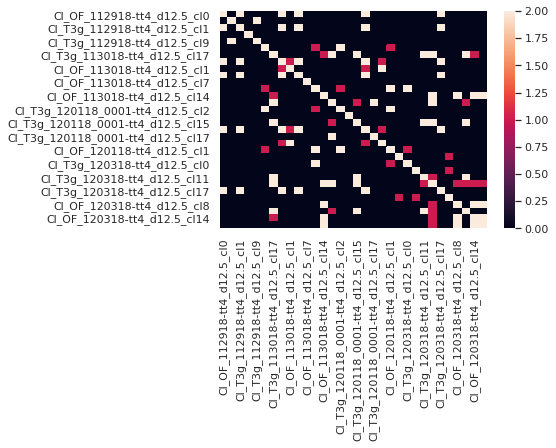

In [314]:
sns.heatmap( 1.0*(dm[14]['dists_mats']['he']<0.5)
            + (dm[14]['dists_mats']['pe']<0.5) )

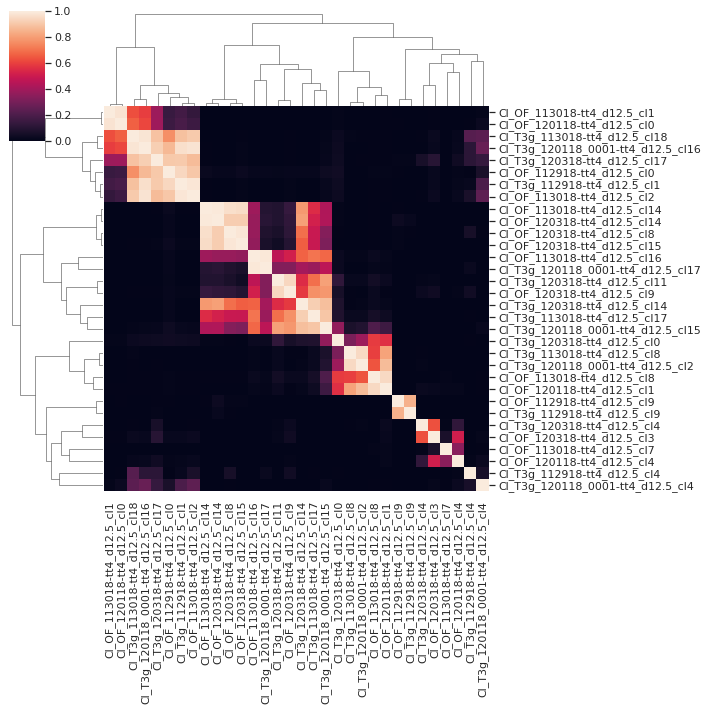

In [326]:
sns.clustermap(1-dm[14]['dists_mats']['pe']/dm[14]['dists_mats']['pe'].max())

/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/seaborn/matrix.py:620: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


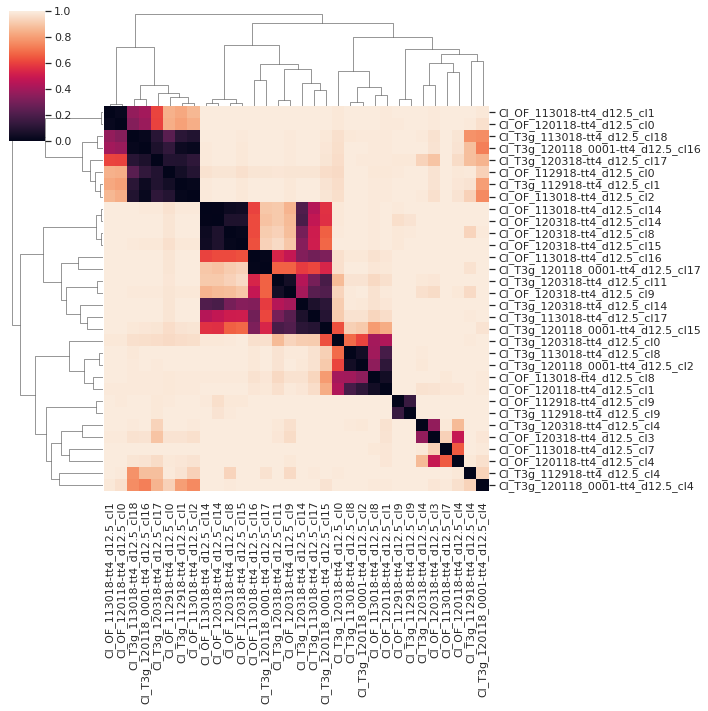

In [328]:
sns.clustermap(dm[14]['dists_mats']['pe'])

In [31]:
wfm = np.median(wf, axis=1)

In [336]:
a = np.zeros(2, dtype=object)
a[0] = [['a','b']]
a[0].append(['c'])
a[0].append('d')
a[0]

[['a', 'b'], ['c'], 'd']

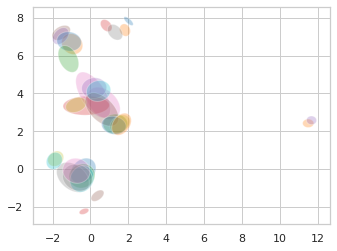

In [351]:
cmf = reload(cmf)

m = dm[analysis_num]['clusters_loc']
s = dm[analysis_num]['clusters_cov']

cmf.plot_2d_cluster_ellipsoids(m, s, std_levels=[1])

In [357]:
cnt = 0
for cl_set in cm[analysis_num]['unique_sets']:
    cnt+= len(cl_set)
    
cnt

35

In [358]:
dm[analysis_num]['analysis']

(4,
 12.5,
 ['Cl_OF_112918',
  'Cl_T3g_112918',
  'Cl_T3g_113018',
  'Cl_OF_113018',
  'Cl_T3g_120118_0001',
  'Cl_OF_120118',
  'Cl_T3g_120318',
  'Cl_OF_120318'],
 32,
 [2, 3, 3, 6, 5, 3, 5, 5])

In [22]:
subject_info.session_clusters[session]['cell_IDs'][tt]

[3, 6, 19, 20]

In [23]:
subject_info.session_clusters[session]['clusters_snr'][tt]

{0: 3.78,
 1: 3.68,
 2: 4.43,
 3: 5.52,
 4: 6.31,
 5: 4.82,
 6: 6.03,
 7: 7.64,
 8: 5.85,
 9: 7.24,
 10: 5.87}

In [24]:
subject_info.session_clusters[session]

{'session': 'Cl_T3g_112918',
 'path': '/mnt/Data2_SSD2T/Data/Sorted/Cl/Cl_T3g_112918',
 'n_cell': 12,
 'n_mua': 30,
 'n_noise': 90,
 'n_unsorted': 95,
 'sorted_TTs': [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 'curated_TTs': [1, 2, 4, 5, 7, 8, 9, 10, 12],
 'cell_IDs': {1: [],
  2: [3, 6, 19, 20],
  4: [1, 4, 9],
  5: [],
  6: [],
  7: [11, 12],
  8: [],
  9: [],
  10: [16],
  11: [],
  12: [12, 13],
  13: [],
  14: [],
  15: [],
  16: []},
 'mua_IDs': {1: [],
  2: [4, 10, 15],
  4: [5, 6, 12, 13, 15],
  5: [2, 7, 12],
  6: [],
  7: [4, 5, 13],
  8: [0, 1],
  9: [7, 9, 13, 16],
  10: [0, 1, 14, 15],
  11: [],
  12: [0, 2, 4, 7, 10, 17],
  13: [],
  14: [],
  15: [],
  16: []},
 'noise_IDs': {1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
  2: [0, 1, 2, 9],
  4: [0, 2, 3, 7, 8, 10, 11, 14],
  5: [0, 1, 3, 5, 6, 8, 10, 11],
  6: [],
  7: [0, 1, 2, 3, 6, 7, 8, 9, 10, 14, 15],
  8: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
  9: [0, 1, 2, 3, 4, 5, 6, 8, 10, 11,

In [9]:
a = subject_info._session_clusters('Cl_OF_112918')
a['clusters_snr'][2]

{0: 3.66,
 1: 2.62,
 2: 19.0,
 3: 10.16,
 4: 3.23,
 5: 2.19,
 6: 2.82,
 7: 3.91,
 8: 5.31,
 9: 6.01,
 10: 5.21,
 11: 4.69,
 12: 7.1,
 13: 6.72,
 14: 7.33,
 15: 8.02,
 16: 4.7}

In [364]:
dm[4]['dists_mats']['pe'].values.flatten()

array([0.        , 0.98448718, 0.32206018, 0.97916492, 0.99775293,
       0.33319639, 0.99993945, 1.        , 0.99673674, 0.99999611,
       0.99941307, 1.        , 0.97652376, 0.99941767, 0.99954068,
       0.98448718, 0.        , 0.99894239, 0.98903623, 0.32098573,
       0.96232428, 0.99999106, 0.99827632, 0.99986197, 1.        ,
       0.85074343, 0.99936456, 0.99456258, 0.94953939, 0.9927447 ,
       0.32206018, 0.99894239, 0.        , 0.99588112, 0.9994071 ,
       0.8955439 , 0.99994615, 1.        , 0.99879549, 0.99999992,
       0.99930225, 1.        , 0.99901875, 0.99999621, 0.9982899 ,
       0.97916492, 0.98903623, 0.99588112, 0.        , 0.98735619,
       0.82990757, 0.99858491, 1.        , 0.98693219, 0.99996485,
       0.99613248, 1.        , 0.17680807, 0.97459844, 0.99993313,
       0.99775293, 0.32098573, 0.9994071 , 0.98735619, 0.        ,
       0.97297853, 0.99999996, 0.9998344 , 0.99999891, 1.        ,
       0.91368565, 1.        , 0.99380702, 0.97939968, 0.98641

In [58]:
 subject_info.session_clusters[session]['clusters_fr'][tt]

{0: 4.21, 1: 11.25, 2: 3.89, 3: 6.21, 4: 3.05, 5: 4.02, 6: 12.41}

In [59]:
session

'Cl_OF_112918'

In [41]:
cl_ids = subject_info.session_clusters[session]['cell_IDs'][tt]

In [44]:
snr = [subject_info.session_clusters[session]['clusters_snr'][tt][cl] for cl in cl_ids]
fr = [subject_info.session_clusters[session]['clusters_fr'][tt][cl] for cl in cl_ids]
isi_vrate = [subject_info.session_clusters[session]['clusters_isi_viol_rate'][tt][cl] for cl in cl_ids]


In [48]:
[subject_info.session_clusters[session]['clusters_isi_viol_rate'][tt][cl] for cl in cl_ids]

[0.35, 1.89, 1.01, 2.67]

In [ ]:
[subject_info.session_clusters[session]['clusters_isi_viol_rate'][tt][cl] for cl in cl_ids]

In [60]:
tt

2

In [61]:
a = np.load("/mnt/Data2_SSD2T/Data/Sorted/Cl/Cl_OF_112918/tt_2/KS2/spike_clusters.npy")

In [79]:
b = pd.read_csv("/mnt/Data2_SSD2T/Data/Sorted/Cl/Cl_OF_010318/tt_10/KS2/cluster_group.tsv", sep='\t')
b

,cluster_id,group
0,0,noise
1,2,noise
2,4,noise
3,5,mua
4,6,noise
5,7,mua
6,8,mua
7,9,mua
8,10,noise
9,11,noise


In [6]:
a = pd.read_csv("/mnt/Data2_SSD2T/Data/Sorted/Cl/Cl_OF_010318/tt_10/KS2/cluster_stats_curated.csv", index_col=0)
a

,cl_num,sorter,fr,isi_viol_rate,n_spikes,n_isi_viol,snr,amp_ch,amp_med_ch,amp_mad_ch,valid,tt_num,group
KS2_0,0.0,KS2,5.515832,5.120115,5329.0,301.0,4.200236,0.0,13.929688,3.570312,False,10,noise
KS2_3,2.0,KS2,0.949150,97.085128,917.0,169.0,2.382449,1.0,28.421875,25.625000,False,10,noise
KS2_5,4.0,KS2,1.080602,2.216020,1044.0,5.0,15.979044,1.0,190.625000,27.000000,True,10,noise
KS2_6,5.0,KS2,2.201572,0.320325,2127.0,3.0,5.600524,1.0,66.812500,18.312500,True,10,mua
KS2_7,6.0,KS2,3.159002,0.259302,3052.0,5.0,3.203366,2.0,35.687500,10.062500,False,10,noise
KS2_8,7.0,KS2,4.096766,0.801727,3958.0,26.0,5.130435,2.0,57.156250,10.468750,True,10,mua
KS2_9,8.0,KS2,3.567850,0.406558,3447.0,10.0,6.159888,2.0,68.625000,14.156250,True,10,mua
KS2_10,9.0,KS2,5.962978,0.218323,5761.0,15.0,6.768828,1.0,80.750000,17.687500,True,10,mua
KS2_11,10.0,KS2,3.659971,0.309079,3536.0,8.0,4.481532,3.0,51.187500,12.531250,False,10,noise
KS2_12,11.0,KS2,3.614428,1.624202,3492.0,41.0,2.270862,3.0,25.937500,10.812500,False,10,noise


In [78]:
a = pd.read_csv("/mnt/Data2_SSD2T/Data/Sorted/Cl/Cl_OF_010318/tt_10/KS2/cluster_stats.csv", index_col=0)
a

,cl_num,sorter,fr,isi_viol_rate,n_spikes,n_isi_viol,snr,amp_ch,amp_med_ch,amp_mad_ch,valid,tt_num
KS2_0,0.0,KS2,5.515832,5.120115,5329.0,301.0,4.200236,0.0,13.929688,3.570312,False,10
KS2_2,1.0,KS2,15.922321,0.138813,15383.0,68.0,8.639162,1.0,103.062500,12.875000,True,10
KS2_3,2.0,KS2,0.949150,97.085128,917.0,169.0,2.382449,1.0,28.421875,25.625000,False,10
KS2_4,3.0,KS2,21.731075,0.220277,20995.0,201.0,9.367387,1.0,111.750000,15.500000,True,10
KS2_5,4.0,KS2,1.080602,2.216020,1044.0,5.0,15.979044,1.0,190.625000,27.000000,True,10
KS2_6,5.0,KS2,2.201572,0.320325,2127.0,3.0,5.600524,1.0,66.812500,18.312500,True,10
KS2_7,6.0,KS2,3.159002,0.259302,3052.0,5.0,3.203366,2.0,35.687500,10.062500,False,10
KS2_8,7.0,KS2,4.096766,0.801727,3958.0,26.0,5.130435,2.0,57.156250,10.468750,True,10
KS2_9,8.0,KS2,3.567850,0.406558,3447.0,10.0,6.159888,2.0,68.625000,14.156250,True,10
KS2_10,9.0,KS2,5.962978,0.218323,5761.0,15.0,6.768828,1.0,80.750000,17.687500,True,10


In [45]:
i0=a.index.values[0]

In [53]:
cl = a.loc[i0,'cl_num'].astype(int)
type(cl)

numpy.int64

In [68]:
keys=a.index.values

{int(a.loc[k, 'cl_num']): int(a.loc[k, 'valid']) for k in keys}

{0: 0,
 1: 0,
 2: 1,
 3: 1,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 1,
 9: 1,
 10: 1,
 11: 0,
 12: 1,
 13: 1,
 14: 1,
 15: 1,
 16: 0}

In [72]:
st='isi_viol_rate'
{int(a.loc[k, 'cl_num']): np.around(a.loc[k, st], 2) for k in keys}

{0: 0.07,
 1: 0.08,
 2: 0.0,
 3: 45.75,
 4: 0.61,
 5: 0.07,
 6: 0.2,
 7: 0.72,
 8: 0.21,
 9: 0.18,
 10: 0.18,
 11: 4.36,
 12: 0.33,
 13: 0.4,
 14: 0.23,
 15: 0.23,
 16: 5.14}

In [109]:
aa = a.copy()

aa.loc[aa.cl_num.isin(b.cluster_id), 'group']=np.array(b.group)
aa

,cl_num,sorter,fr,isi_viol_rate,n_spikes,n_isi_viol,snr,amp_ch,amp_med_ch,amp_mad_ch,valid,tt_num,group
KS2_0,0.0,KS2,13.797953,0.065873,14853.0,27.0,3.663438,0.0,23.640625,5.093750,False,2,noise
KS2_1,1.0,KS2,7.833982,0.083253,8433.0,11.0,2.619855,0.0,16.906250,4.968750,False,2,noise
KS2_2,2.0,KS2,0.418035,0.000000,450.0,0.0,19.002421,0.0,122.625000,18.093750,True,2,noise
KS2_3,3.0,KS2,0.318636,45.748965,343.0,10.0,10.159806,0.0,65.562500,18.250000,True,2,noise
KS2_4,4.0,KS2,7.969612,0.614293,8579.0,84.0,3.227603,0.0,20.828125,4.828125,False,2,noise
KS2_5,5.0,KS2,20.680673,0.067334,22262.0,62.0,2.187651,0.0,14.117188,5.070312,False,2,noise
KS2_6,6.0,KS2,6.773102,0.202500,7291.0,20.0,2.815981,0.0,18.171875,4.968750,False,2,noise
KS2_7,7.0,KS2,5.720581,0.723870,6158.0,51.0,3.912833,0.0,25.250000,5.796875,False,2,noise
KS2_8,8.0,KS2,4.207294,0.209921,4529.0,8.0,5.305318,1.0,63.125000,12.656250,True,2,mua
KS2_9,9.0,KS2,11.247938,0.176224,12108.0,48.0,6.009192,1.0,71.500000,11.812500,True,2,good


In [128]:
units_with_stats = a.cl_num.values.astype(int)
units = b.cluster_id.values
units = units[2:]

In [129]:
np.setdiff1d(units, units_with_stats)

array([], dtype=int64)

In [147]:
aa = a[ a.cl_num.isin([2,4,5,6,11]) ].copy()
aa

,cl_num,sorter,fr,isi_viol_rate,n_spikes,n_isi_viol,snr,amp_ch,amp_med_ch,amp_mad_ch,valid,tt_num
KS2_2,2.0,KS2,0.418035,0.000000,450.0,0.0,19.002421,0.0,122.625000,18.093750,True,2
KS2_4,4.0,KS2,7.969612,0.614293,8579.0,84.0,3.227603,0.0,20.828125,4.828125,False,2
KS2_5,5.0,KS2,20.680673,0.067334,22262.0,62.0,2.187651,0.0,14.117188,5.070312,False,2
KS2_6,6.0,KS2,6.773102,0.202500,7291.0,20.0,2.815981,0.0,18.171875,4.968750,False,2
KS2_11,11.0,KS2,3.996418,4.362345,4302.0,150.0,4.689076,2.0,52.312500,13.484375,False,2


In [165]:
su1 = [3,11, 5]
su2 = [4,8]

In [202]:
x = aa[aa.cl_num.isin(su1)].copy()
x = x.append(aa[aa.cl_num.isin(su2)])
x

,cl_num,sorter,fr,isi_viol_rate,n_spikes,n_isi_viol,snr,amp_ch,amp_med_ch,amp_mad_ch,valid,tt_num
KS2_5,5.0,KS2,20.680673,0.067334,22262.0,62.0,2.187651,0.0,14.117188,5.070312,False,2
KS2_11,11.0,KS2,3.996418,4.362345,4302.0,150.0,4.689076,2.0,52.312500,13.484375,False,2
KS2_4,4.0,KS2,7.969612,0.614293,8579.0,84.0,3.227603,0.0,20.828125,4.828125,False,2


In [180]:
x = x.sort_values('cl_num')
x

,cl_num,sorter,fr,isi_viol_rate,n_spikes,n_isi_viol,snr,amp_ch,amp_med_ch,amp_mad_ch,valid,tt_num
KS2_4,4.0,KS2,7.969612,0.614293,8579.0,84.0,3.227603,0.0,20.828125,4.828125,False,2
KS2_5,5.0,KS2,20.680673,0.067334,22262.0,62.0,2.187651,0.0,14.117188,5.070312,False,2
KS2_11,11.0,KS2,3.996418,4.362345,4302.0,150.0,4.689076,2.0,52.312500,13.484375,False,2


In [171]:

x.cl_num.isin([4,5,11])

KS2_5     True
KS2_11    True
KS2_4     True
Name: cl_num, dtype: bool

In [206]:
su3=[4,11]
x['group'] = '-'
x.loc[x.cl_num.isin(su3),'group'] = b.loc[b.cluster_id.isin(su3),'group'].values
x

,cl_num,sorter,fr,isi_viol_rate,n_spikes,n_isi_viol,snr,amp_ch,amp_med_ch,amp_mad_ch,valid,tt_num,group
KS2_5,5.0,KS2,20.680673,0.067334,22262.0,62.0,2.187651,0.0,14.117188,5.070312,False,2,-
KS2_11,11.0,KS2,3.996418,4.362345,4302.0,150.0,4.689076,2.0,52.312500,13.484375,False,2,noise
KS2_4,4.0,KS2,7.969612,0.614293,8579.0,84.0,3.227603,0.0,20.828125,4.828125,False,2,noise


In [211]:
y = pd.DataFrame(columns=['cl_num'])
yy = y.cl_num.values.astype(int)
yy

array([], dtype=int64)

In [213]:
np.intersect1d(units,yy)

array([], dtype=int64)